In [1]:
import json
import copy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs
from geopy.distance import great_circle as  distance

/home/ian/anaconda3/envs/py3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ian/anaconda3/envs/py3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
def merge_lines(feature_collection):
    features = copy.deepcopy(feature_collection['features'])
    ordered_coords = [features.pop()['geometry']['coordinates']]
    while len(features) > 0:
        min_dist = 1.e6
        idx = 0
        reverse = False
        insert_idx = 0
        for i, feature in enumerate(features):
            coord_list = feature['geometry']['coordinates']
            front_feat = coord_list[0][::-1]
            back_feat = coord_list[-1][::-1]
            front_coords = ordered_coords[0][0][::-1]
            back_coords = ordered_coords[-1][-1][::-1]
            d1 = distance(front_coords, front_feat)
            d2 = distance(front_coords, back_feat)
            d3 = distance(back_coords, front_feat)
            d4 = distance(back_coords, back_feat)
            
            if d1 < min_dist:
                min_dist = d1
                idx = i
                insert_idx = 0
                reverse = True

            if d2 < min_dist:
                min_dist = d2
                idx = i
                insert_idx = 0
                reverse = False

            if d3 < min_dist:
                min_dist = d3
                idx = i
                insert_idx = len(ordered_coords)
                reverse = False

            if d4 < min_dist:
                min_dist = d4
                idx = i
                insert_idx = len(ordered_coords)
                reverse = True

        feature = features.pop(idx)
        coords = feature['geometry']['coordinates']
        coords = coords[::-1] if reverse else coords
        ordered_coords.insert(insert_idx, coords)
    return [item for sublist in ordered_coords for item in sublist]

In [3]:
data = json.load(open('shapefiles/gold.geo.json'))
c = np.array(merge_lines(data))
c.shape

(1338, 2)

In [4]:
d = np.zeros(c.shape[0])
d.shape

(1338,)

In [5]:
for i, point in enumerate(c):
    if i == 0:
        continue
    d[i] = distance(c[i-1][::-1], c[i][::-1]).km    

In [6]:
cumulative_distance = np.cumsum(d)
total_distance = cumulative_distance[-1]
total_distance

49.63789011062935

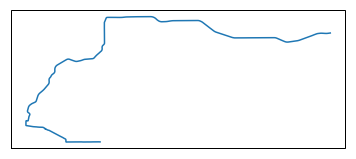

In [7]:
ax = plt.axes(projection=ccrs.Mercator())
plt.plot(c[:,0], c[:,1], transform=ccrs.PlateCarree())

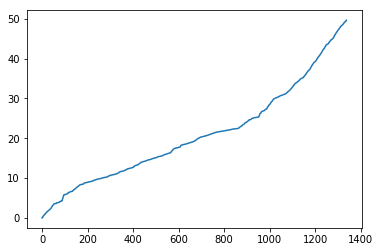

In [8]:
plt.plot(cumulative_distance)

In [9]:
def get_nearest_point_index(pt, route):
    d = np.fromiter((distance(r[::-1], pt[::-1]).km for r in route), dtype=float)
    return np.argmin(d)

In [10]:
df = pd.read_csv('sample_tracking_data.csv')

In [11]:
df['distance'] = df.apply(lambda x: cumulative_distance[get_nearest_point_index((x['lon'], x['lat']), c)], axis=1)

In [12]:
df['date'] = pd.to_datetime(df['timestamp'],unit='s')

In [13]:
northbound = df.loc[df['direction'] == 0.].groupby('vehicle_id')
southbound = df.loc[df['direction'] == 180.].groupby('vehicle_id')

In [14]:
stations = json.load(open('misc/GoldLineStationIds.json'))['items']
station_distances = [cumulative_distance[get_nearest_point_index((station['longitude'], station['latitude']), c)] for station in stations]

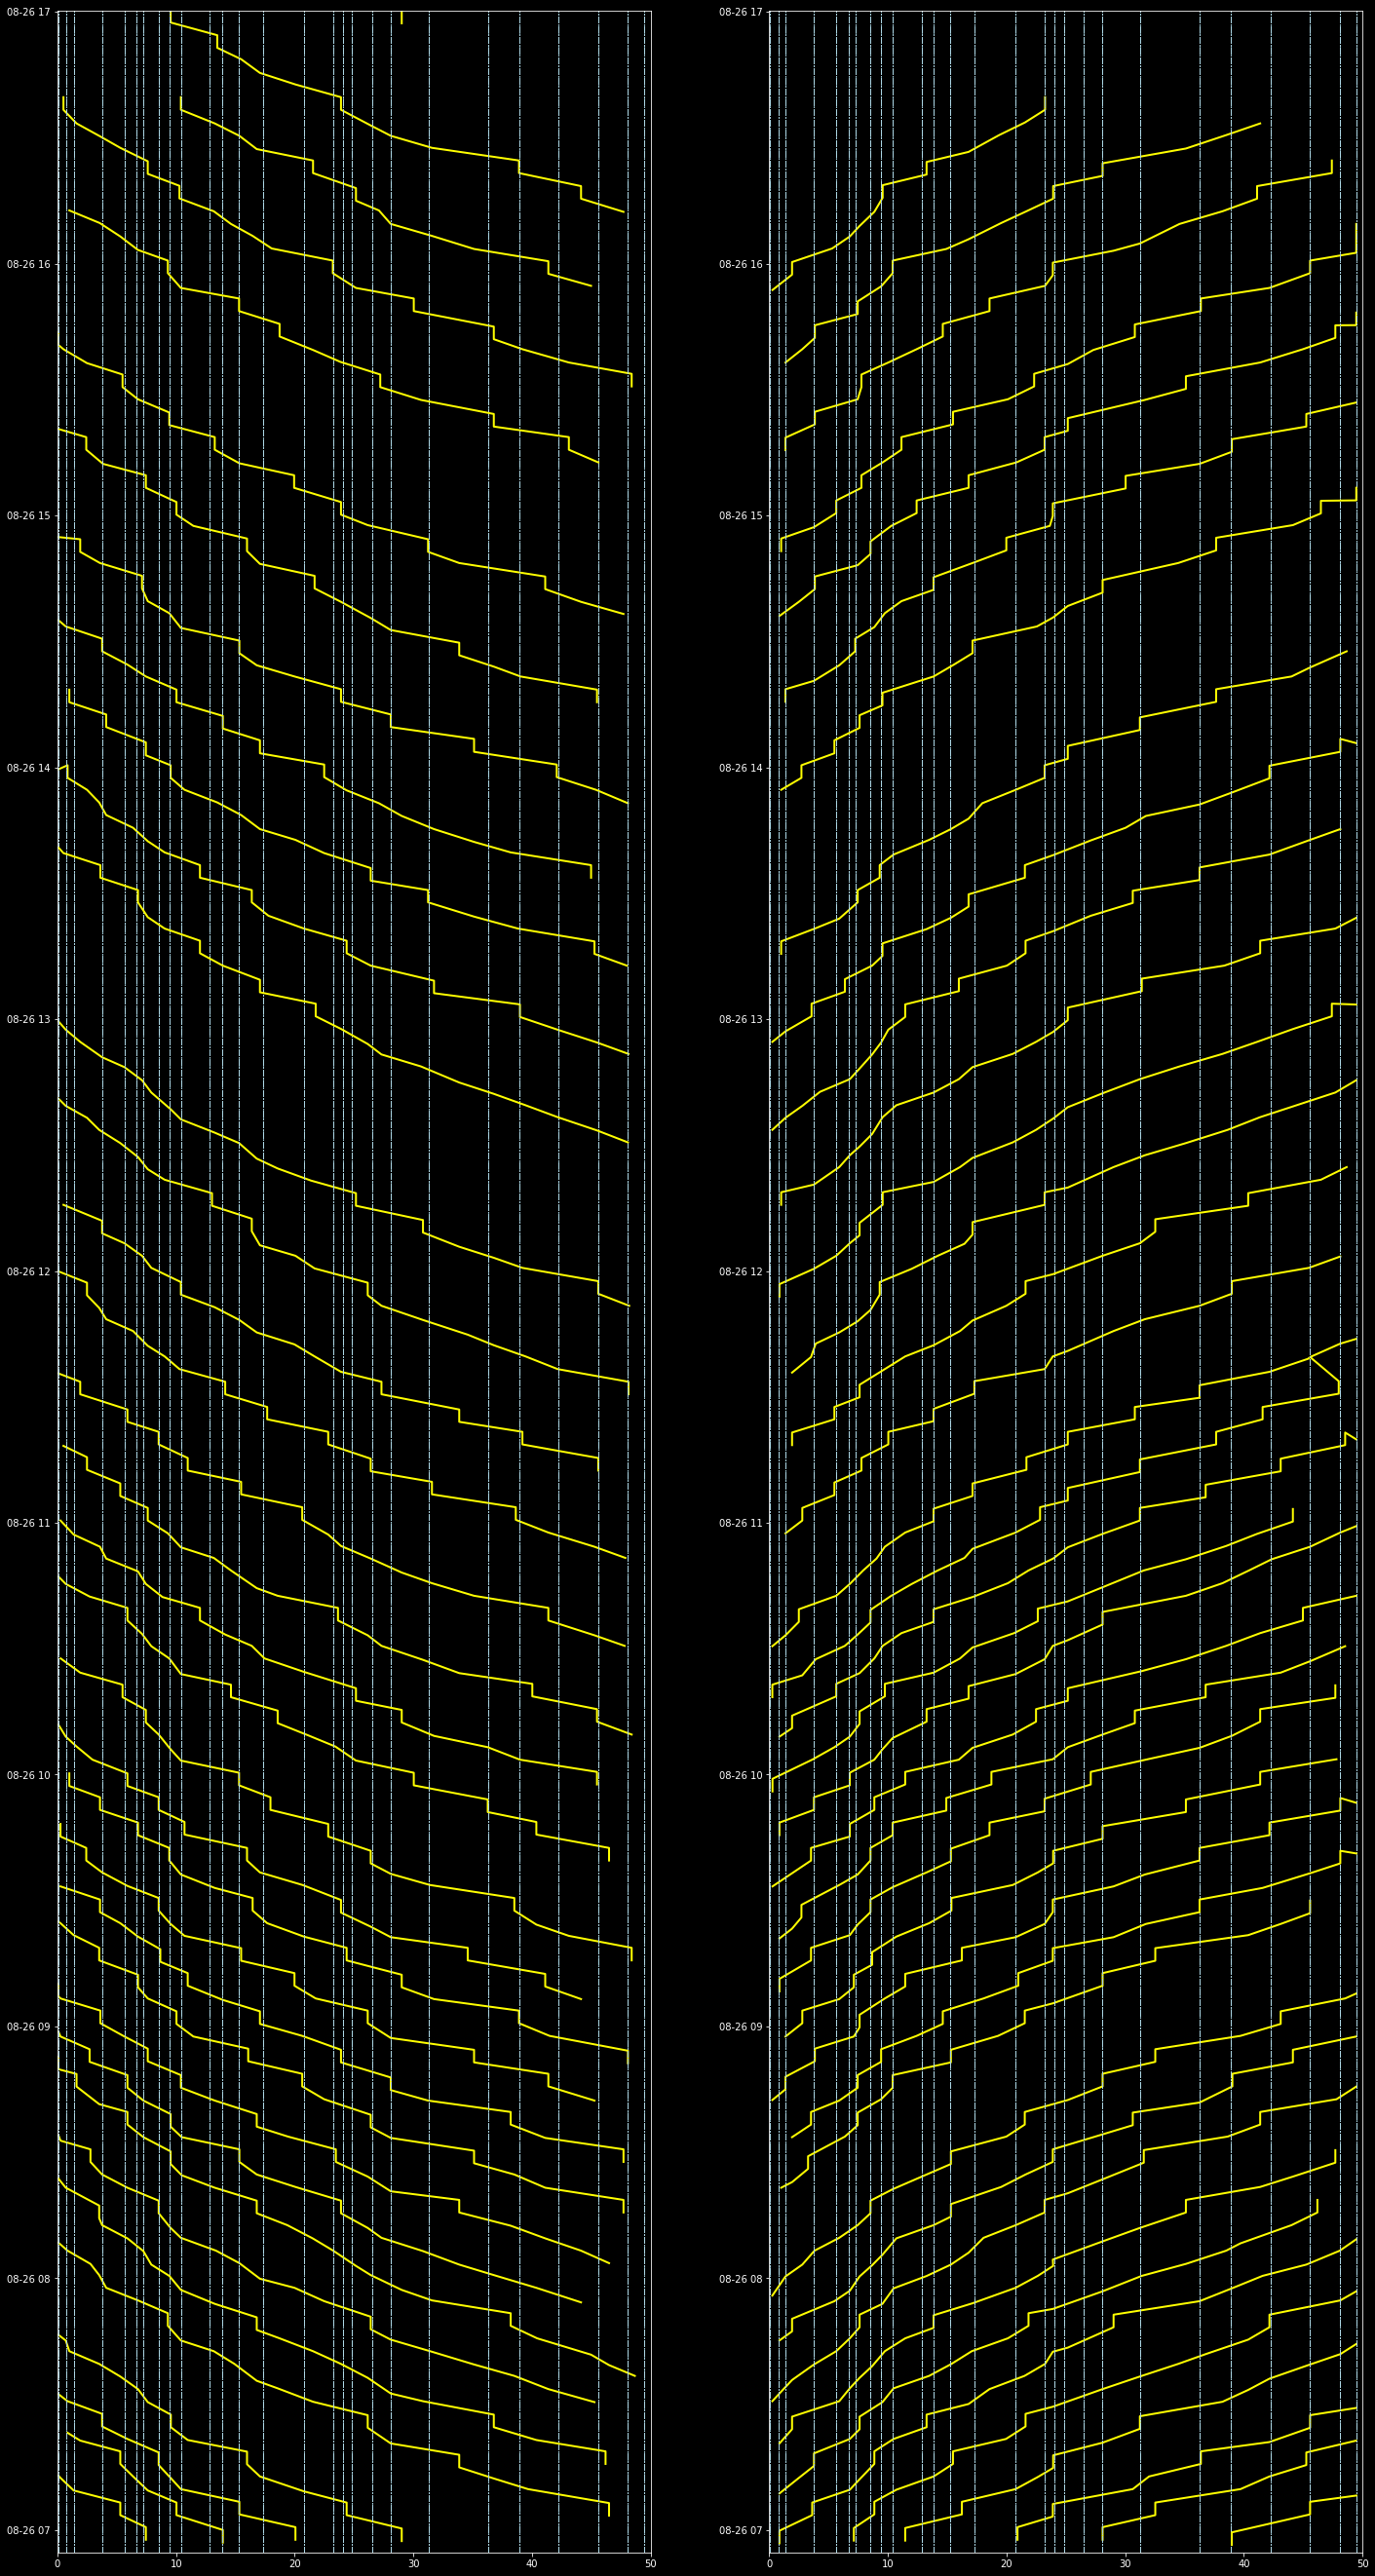

In [34]:
plt.style.use('dark_background')

fig = plt.figure(figsize=[24,48])
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.set_ylim(df['date'].min(),df['date'].max())
ax2.set_ylim(df['date'].min(),df['date'].max())
ax1.set_xlim(0, 50)
ax2.set_xlim(0, 50)

for group in southbound:
    times = group[1]['date']
    distances = group[1]['distance'].values
    nans = np.where(np.abs(np.diff(distances)) >= 10.0)[0]
    distances[nans] = np.nan
    for station in station_distances:
        ax1.axvline(station, color='#ADD8E6', lw=1, linestyle='-.')
    ax1.plot(distances, times, lw=2, color='#FFFF00')
for group in northbound:
    times = group[1]['date']
    distances = group[1]['distance'].values
    nans = np.where(np.abs(np.diff(distances)) >= 10.0)[0]
    distances[nans] = np.nan
    for station in station_distances:
        ax2.axvline(station, color='#ADD8E6', lw=1, linestyle='-.')
    ax2.plot(distances, times, lw=2, color='#FFFF00')

* Average time between trains
* Average wait time
* Max wait time
* Max time between trains
